In [53]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.scalar_mediator import ScalarMediator
from hazma.vector_mediator import VectorMediator
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import (energy_res_e_astrogam,
                                                               A_eff_e_astrogam,
                                                               egret_diffuse,
                                                               fermi_diffuse,
                                                               comptel_diffuse,
                                                               gc_bg_model_target,
                                                               gc_bg_model)

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

# Load relic density curve
This isn't really worth plotting: it's right near standard $3\times 10^{-26} \text{cm}^3 / \text{s}$ value.

In [71]:
rd_mxs, rd_svs = np.loadtxt("relic_abundance.dat", delimiter=",").T
rd_mxs = 10.**rd_mxs
rd_svs = 10.**rd_svs

# Scalar mediator

## Setup

In [54]:
s_theta = 0.5
sm_hp = ScalarMediator(mx=1., ms=1000., gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# Masses to scan over
mx_min = 0.55
mx_max = 3000.
n_mxs = 50
mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)

## Recompute constraints

In [9]:
sm_lims_egret = sm_hp.binned_limits(mxs, egret_diffuse)
sm_lims_comptel = sm_hp.binned_limits(mxs, comptel_diffuse)
sm_lims_fermi = sm_hp.binned_limits(mxs, fermi_diffuse)

# np.savetxt("data/sm_lims_egret.csv",
#            np.array([mxs, sm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/sm_lims_comptel.csv",
#            np.array([mxs, sm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/sm_lims_fermi.csv",
#            np.array([mxs, sm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/hazma/gamma_ray_limits/compute_limits.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  sv_lims.append(phi_max / phi_dm)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: Integr

In [9]:
sm_lims_e_astrogam = sm_hp.unbinned_limits(mxs, target_params=gc_bg_model_target, bg_model=gc_bg_model)

# np.savetxt("data/sm_lims_e_astrogam.csv",
#            np.array([mxs, sm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

e_a: 0.061645 -> 0.061645
e_b: 0.184936 -> 0.184936
 


KeyboardInterrupt: 

## Load previously computed constraints

In [59]:
sm_mxs, sm_lims_egret = np.loadtxt("data/sm_lims_egret.csv", delimiter=",").T
sm_mxs, sm_lims_comptel = np.loadtxt("data/sm_lims_comptel.csv", delimiter=",").T
sm_mxs, sm_lims_fermi = np.loadtxt("data/sm_lims_fermi.csv", delimiter=",").T
sm_mxs, sm_lims_e_astrogam = np.loadtxt("data/sm_lims_e_astrogam.csv", delimiter=",").T

## Plot results

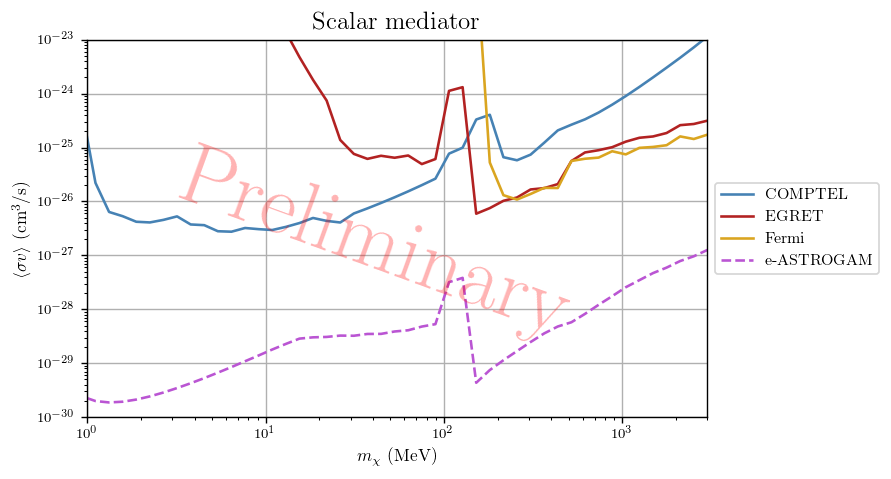

In [73]:
plt.figure(figsize=(8, 4))

plt.plot(sm_mxs, sm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(sm_mxs, sm_lims_egret, label="EGRET", color=colors[1])
plt.plot(sm_mxs, sm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(sm_mxs, sm_lims_e_astrogam, '--', label="e-ASTROGAM", color=colors[3])

plt.xlim([1, sm_mxs[-1]])
plt.ylim([1e-30,1e-23])
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Scalar mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.text(3, 1e-26, 'Preliminary', fontsize=50, color='red', alpha=0.3, rotation=-20)
# plt.savefig("figures/sm_sigmav_limits.pdf")

# Vector mediator

## Setup

In [84]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 140., 250., 50
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [20]:
vm_lims_comptel = vm.binned_limits(vm_mxs, comptel_diffuse)
vm_lims_egret = vm.binned_limits(vm_mxs, egret_diffuse)
vm_lims_fermi = vm.binned_limits(vm_mxs, fermi_diffuse)

# np.savetxt("data/vm_lims_comptel.csv",
#            np.array([vm_mxs, vm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_egret.csv",
#            np.array([vm_mxs, vm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_fermi.csv",
#            np.array([vm_mxs, vm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [21]:
vm_lims_e_astrogam = vm.unbinned_limits(vm_mxs, target_params=gc_bg_model_target, bg_model=gc_bg_model)

# np.savetxt("data/vm_lims_e_astrogam.csv",
#            np.array([vm_mxs, vm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

KeyboardInterrupt: 

## Load previously computed constraints

In [85]:
vm_mxs, vm_lims_egret = np.loadtxt("data/vm_lims_egret.csv", delimiter=",").T
vm_mxs, vm_lims_comptel = np.loadtxt("data/vm_lims_comptel.csv", delimiter=",").T
vm_mxs, vm_lims_fermi = np.loadtxt("data/vm_lims_fermi.csv", delimiter=",").T
vm_mxs, vm_lims_e_astrogam = np.loadtxt("data/vm_lims_e_astrogam.csv", delimiter=",").T

## Plot results

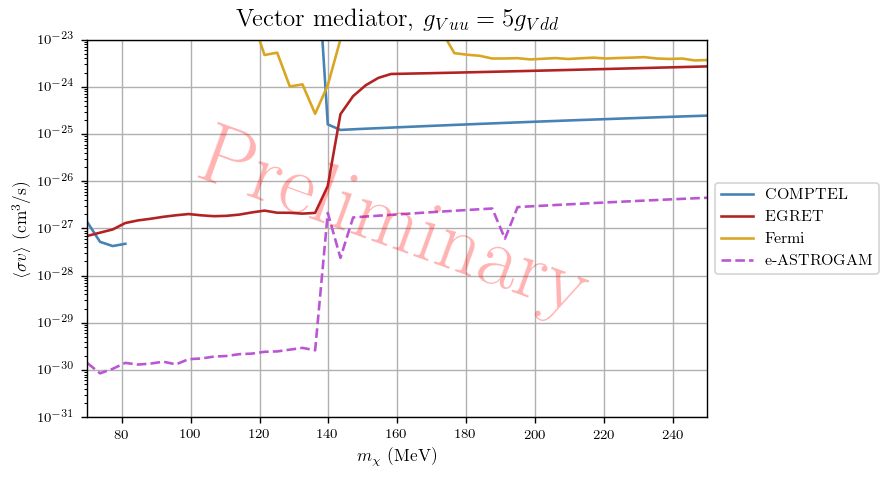

In [86]:
plt.figure(figsize=(8, 4))

plt.plot(vm_mxs, vm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(vm_mxs, vm_lims_egret, label="EGRET", color=colors[1])
plt.plot(vm_mxs, vm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(vm_mxs, vm_lims_e_astrogam, '--', label="e-ASTROGAM", color=colors[3])

plt.xlim(vm_mxs[[0, -1]])
plt.ylim([1e-31,1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title(r"Vector mediator, $g_{Vuu} = %i g_{Vdd}$" % (vm.gvuu/vm.gvdd))

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.text(100, 1e-26, 'Preliminary', fontsize=50, color='red', alpha=0.3, rotation=-20)
plt.savefig("figures/vm_sigmav_limits.pdf")

## Look out how constraints vary with couplings

In [39]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 140., 180., 30
mxs = np.linspace(mx_min, mx_max, n_mxs)

# Couplings to scan over
# gvdds = np.linspace(-0.5, 1.5, 5)
gvdds = np.array([-0.5, 0.9, 1., 2.])

In [44]:
# Compute EGRET limits for the different couplings
# vm_lims_egret_gvdd = []

for gvdd in gvdds[2:]:
    print "gvdd = %f" % gvdd
    vm.gvdd = gvdd
    vm_lims_egret_gvdd.append(vm.binned_limits(mxs, egret_diffuse))

gvdd = 1.000000
gvdd = 2.000000


In [45]:
# Set up the colormap
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=gvdds[0], vmax=gvdds[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)

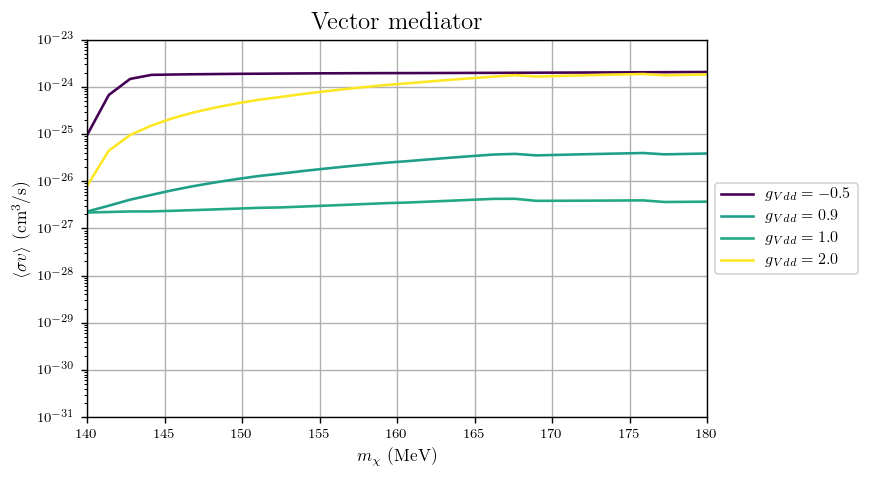

In [48]:
plt.figure(figsize=(8, 4))

for gvdd, lims in zip(gvdds, vm_lims_egret_gvdd):
    plt.plot(mxs, lims, label=r"$g_{Vdd}=%.1f$" % gvdd,
             color=m.to_rgba(gvdd))

# Formatting
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-31,1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Vector mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Scratch/testing

(1e-10, 1.0)

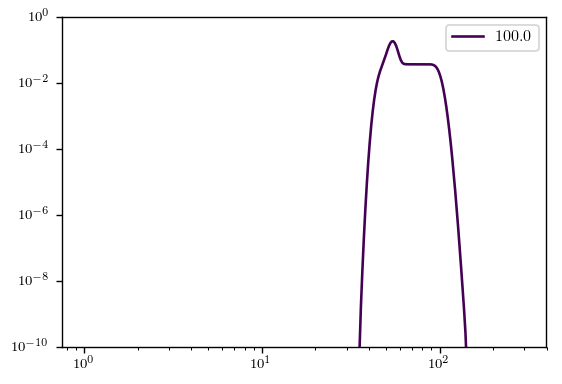

In [23]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import energy_res_comptel
import matplotlib.cm as cm
from matplotlib.colors import Normalize

vm = VectorMediator(mx=1., mv=201., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# mx_min, mx_max, n_mxs = 70, 200., 4
# mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)
mxs = np.array([100.])

cmap = cm.viridis
norm = Normalize(vmin=np.log10(mxs[0]), vmax=np.log10(mxs[-1]))

e_gams = np.logspace(0, np.log10(300), 300)

for mx in mxs:
    vm.mx = mx
    e_cm = 2.*vm.mx*(1.+0.5*1e-6)

    dnde_det = get_detected_spectrum(e_gams, vm.spectra(e_gams, e_cm)["total"], *vm.gamma_ray_lines(e_cm), energy_res=energy_res_comptel)
    
    plt.loglog(e_gams, dnde_det(e_gams), color=cmap(norm(np.log10(mx))), label="%.1f" % mx)
    
plt.legend()
plt.ylim(1e-10, 1e0)

In [30]:
for fm in [comptel_diffuse, egret_diffuse, fermi_diffuse]:
    print fm.bins[0][0], fm.bins[-1][-1]

0.7703084693028202 27.618455799248043
27.618455799248043 8626.25729321894
153.2191922762135 94968.96255955588


In [17]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

mx = 200.
vm.mx = mx
e_cm = 2.*vm.mx * (1. + 0.5*1e-6)

e_gams = np.logspace(np.log10(A_eff_e_astrogam.x[0])-1,
                     np.log10(A_eff_e_astrogam.x[-1])+1, 75)
dndes = vm.spectra(e_gams, e_cm)["total"]

dnde_det = get_detected_spectrum(e_gams, dndes, *vm.gamma_ray_lines(e_cm), energy_res=energy_res_e_astrogam)

In [18]:
e_min = max(A_eff_e_astrogam.x[0],
            dnde_det.x[np.where(dnde_det.y)[0][0]])
e_max = min(A_eff_e_astrogam.x[-1],
            dnde_det.x[np.where(dnde_det.y)[0][-1]])
e_dnde_max = dnde_det.x[np.argmax(dnde_det.y)]
print(e_min, e_max, e_dnde_max)

e_a_0 = 10.**(0.5 * (np.log10(e_dnde_max) + np.log10(e_min)))
e_b_0 = 10.**(0.5 * (np.log10(e_max) + np.log10(e_dnde_max)))

(0.3, 3000.0, 0.03615782810612527)


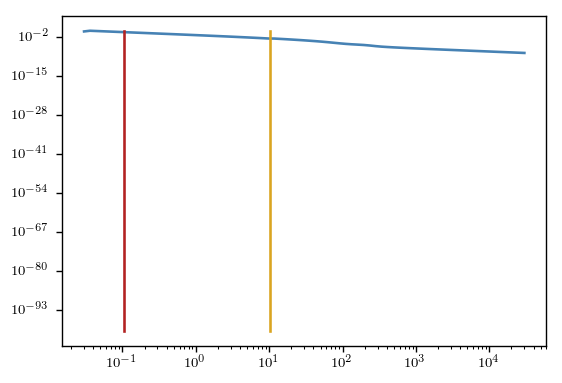

In [19]:
plt.loglog(e_gams, dnde_det(e_gams))
plt.loglog(2*[e_a_0], [1e-100, 1e0])
plt.loglog(2*[e_b_0], [1e-100, 1e0])